# Modelo creado mendiante el uso de `API de CSi`

## Dependecias

In [ ]:
import os, sys, numpy as np

from matplotlib import pyplot as plt

import comtypes.client
import ctypes

## geometria del modelo

In [2]:
# unidades
kN_m_C = 6
kgf_m_C = 8
Tonf_m_C = 12

In [ ]:
fc = 280;
material_type = 2;
material_name = f'fc={str(fc)} kg/cm^2'; # fc=280kg/cm^2
# 
E = 150000*fc*0.5; # kg/cm^2
v = 0.2
coeficienteTermico = 0.0000055 #T

# secciones para la viga y columna
secBeamb = 0.3 # cm
secBeamh = 0.6 # cm
beamName = f'V{str(secBeamb)}x{str(secBeamh)}'
secColumnb = 0.3 # cm
secColumnh = 0.6 # cm
columnName = f'C{str(secColumnb)}x{str(secColumnh)}'

l1, l2, h = 3, 4, 2.80
# vertices o coordenadas
coords = np.array([
    [0, 0, 0],      # vertice o nodo 1
    [l1, 0, 0],     # nodo 3
    [l1+l2, 0, 0],  # nodo 4
    [0, 0, h],      # nodo 2
    [l1, 0, h],     # nodo 5
    [l1+l2, 0, h]   # nodo 6
]) # [m]

# miembros o elementos
# elems[node_i, node_j, columna o viga]
elems = np.array([
    [0,3, 'c'],  # elemento 1
    [1,4, 'c'],  # elemento 2
    [2,5, 'c'],  # elemento 3
    [3,4, 'v'],  # elemento 4
    [4,5, 'v']   # elemento 5
])

# Restricciones o condiciones de 
# apoyos[idNode, Fx, Fy, Fz, Rx, Ry, Rz]
apoyos = np.array([
    [0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1],
    [2, 1, 1, 1, 1, 1, 1]
]);

# cargas puntual
# cargas[idNodo, Fx, Fy, Fz, Rx, Ry, Rz]
cargas = np.array([
    [4, 0,0,-10,0,0,0],
    [6, 0,0,-10,0,0,0]
])
# carga distribuidas
# cargasDistr[idElem, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga, node_i, node_j, F/L, [1:g,2:r,3:b], i, j, tipoCarga]
cargasDistr = np.array([
    [4, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.4, -0.4, 1, 2, 0, 1, "Live"],
    [5, -0.4, -0.4, 1, 2, 0, 1, "Dead", -0.25, -0.25, 1, 2, 0, 1, "Live"]
])

# Indicar el programa a usar
connect_to = 1; #1 para SAP2000 y 2 para ETABS
# Variable para definir una instancia manual para el programa y definir la ruta.
rutaEspecifica = False

nn = np.shape(coords)[0]
ne = np.shape(elems)[0]

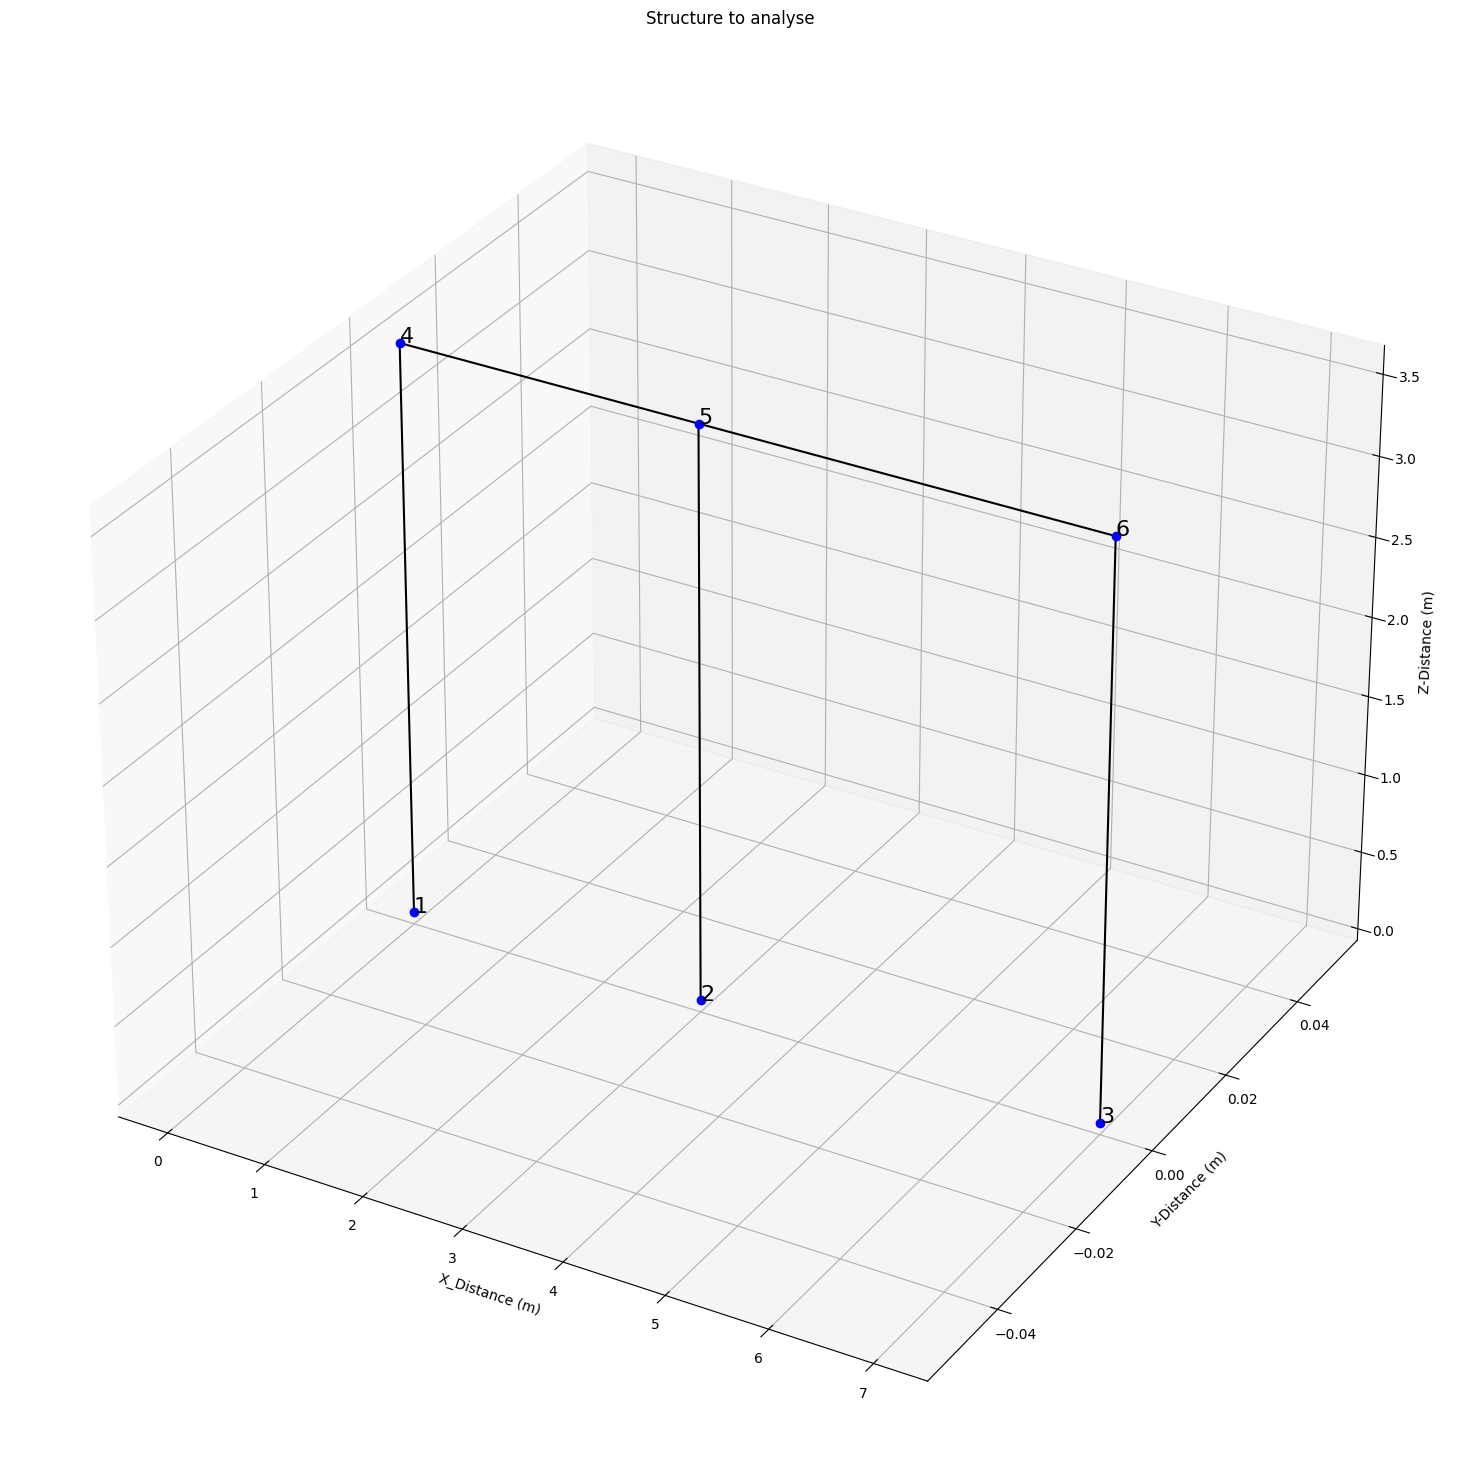

In [6]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1, 3,3], projection='3d') # Indicate a 3D plot
#axes.view_init(20, 60) # Set the viewing angle of the 3D plot

#Plot members
for mbr in elems:
    node_i = int(mbr[0]) #Node number for node i of this member
    node_j = int(mbr[1]) #Node number for node j of this member

    ix = coords[node_i,0] #x-coord of node i of this member
    iy = coords[node_i,1] #y-coord of node i of this member
    iz = coords[node_i,2] #z-coord of node i of this member
    jx = coords[node_j,0] #x-coord of node j of this member
    jy = coords[node_j,1] #y-coord of node j of this member
    jz = coords[node_j,2] #z-coord of node j of this member

    # Calculate direction cosines
    dx = jx-ix #x-component of vector along member
    dy = jy-iy #y-component of vector along member
    dz = jz-iz #z-component of vector along member
    mag = np.sqrt(dx**2 + dy**2 + dz**2) # Magnitude of vector (length of member)

    axes.plot3D([ix,jx],[iy,jy],[iz,jz],'k') # Plot 3D node

#Plot coords
for n, node in enumerate(coords):
    axes.plot3D([node[0]],[node[1]], [node[2]],'ob', ms=6) # Plot 3D node
    label = str(n+1) # Node number label
    axes.text(node[0], node[1], node[2], label, fontsize=16) # Add node label

# Make the aspect ratio equal
#fig.gca().set_aspect('equal', adjustable='box') # comentar en caso de usar margenes ajustados

axes.set_xlabel('X_Distance (m)')
axes.set_ylabel('Y-Distance (m)')
axes.set_zlabel('Z-Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()

## Coneccion

In [8]:
smodel, ret = None, None
conn = {};
if connect_to == 1:  # SAP2000
    print("SAP2000")
    conn = {
        'app_ruta': "C:\\Program Files\\Computers and Structures\\SAP2000 26\\SAP2000.exe",
        'app_adjunto': "CSI.SAP2000.API.SapObject",
        'app_helper': 'SAP2000v1.Helper'
        }
elif (connect_to == 2): # ETABS
    print("ETABS")
    conn = {
        'app_ruta': "C:\\Program Files\\Computers and Structures\\ETABS 21\\ETABS.exe",
        'app_adjunto': "CSI.ETABS.API.ETABSObject",
        'app_helper': "ETABSv1.Helper"
        }
else: 
    print("No tenemos soporte aun")
    sys.exit()

SAP2000


In [ ]:
try:
    connect_to_app = comtypes.client.GetActiveObject(conn['app_adjunto'])
    print("Coneccion exitosa!.\nadjuntando a una instancia existente.")
except (OSError, comtypes.COMError):
    print("No se encontró ninguna instancia en ejecución del programa(Etabs).")

    print("Tratando de Ejecutar otras opcciones!.")
    #create API helper object
    helper = comtypes.client.CreateObject(conn['app_helper'])
    if connect_to == 1:
        helper = helper.QueryInterface(comtypes.gen.SAP2000v1.cHelper)
    else:
        helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper);
    # helper = comtypes.client.CreateObject(conn['app_helper']).QueryInterface()
    if rutaEspecifica: # para versiones anteriores a la ultima version instalada
        ProgramPath = conn['app_ruta'];
        try:
            connect_to_app = helper.CreateObject(ProgramPath)
            print("Coneccion establecida!.\nConexion Manual")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program from " + ProgramPath)
            sys.exit(-1)
    else:
        try: 
            connect_to_app = helper.CreateObjectProgID(conn['app_adjunto']) 
            print("Coneccion establecida!.")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program.")
            sys.exit(-1)
    print("Ejecutando!.  ultima version instalada o existente")
    #start ETABS application | ejecutar la Aplicacion ETABS.
    connect_to_app.ApplicationStart()

smodel = connect_to_app.SapModel;

No se encontró ninguna instancia en ejecución del programa(Etabs).
Tratando de Ejecutar etabs!.
Coneccion establecida!.
Ejecutando!.  ultima version instalada o existente


## Se crea un nuevo Lienzo y Modelo

In [10]:
smodel.SetModelIsLocked(False)

# Se crea un nuevo lienzo
# smodel.InitializeNewModel; # esto es valido tambien
smodel.InitializeNewModel(Tonf_m_C)

response_status = smodel.File.NewBlank() # response es a respuesta
response_status

0

## Se establece las propiedades del concreto

In [11]:
# definicion del material
response_status = smodel.PropMaterial.SetMaterial( material_name, material_type )

# propiedades mecanicas del material
response_status = smodel.PropMaterial.SetMPIsotropic( material_name, E, v, coeficienteTermico )
display(response_status)

0

In [12]:
# Secciones de viga y columna
response_status = smodel.PropFrame.SetRectangle(beamName, material_name, secBeamb, secBeamh) # seecion para la viga
response_status = smodel.PropFrame.SetRectangle(columnName, material_name, secColumnb, secColumnh) # seccion para la columna
display(response_status)

0

In [9]:
# # modificadores de propiedad de seccion de marco
# ModValue = [1000, 0,0,1,1,1,1,1]
# response_status = smodel.PropFrame.SetModifiers(nombreViga, ModValue)
# response_status = smodel.PropFrame.SetModifiers(nombreColumna, ModValue)

## Geometria de la estructura

`Sintax` vertice o coordenadas

En lenguaje `C#` 
```c#
int AddCartesian(
	double X,
	double Y,
	double Z,
	ref string Name,
	string UserName = "",
	string CSys = "Global",
	bool MergeOff = false,
	int MergeNumber = 0
)
```
Su equivalente en `python`
```py
AddCartesian(
	X: float,
	Y: float,
	Z: float,
	Name: str,
	UserName = "",      # referencia a un str
	CSys = "Global",    # referencia a un str
	MergeOff = false,   # referencia a un bool
	MergeNumber = 0     # referencia a un int
) -> int
```

`Sintax` Elementos o miembros de coneccion

En lenguaje `C#` 
```c#
int AddByPoint(
	string Point1,
	string Point2,
	ref string Name,
	string PropName = "Default",
	string UserName = ""
)
```
Su equivalente en `python`
```py
AddByPoint(
	Point1: str,
	Point2: str,
	Name: str, # referncia
	PropName = "Default",
	UserName = ""
) -> int
```

In [10]:
# response_status = None; # flag(bandera) que nos indica la respuesta de exito o fracaso 
# # Vertices o coordenadas
# FrameName = ' '
# for i in range(nn):
#     [FrameName, response_status] = smodel.PointObj.AddCartesian(coords[i,0], coords[i,1], coords[i,2], str(i+1))
#     # if not response_status: print('ok')
#     # else: print(f'failed in {i}')

# Conecciones, elementos o  miembros
# ...

In [13]:
# 2da forma de ingreso
FrameName1 = ''
for idx, mbr in enumerate(elems):
    deNodo = int(mbr[0])
    alNodo = int(mbr[1])
    identificador = mbr[2] # columna o viga
    xi, yi, zi = coords[deNodo, 0], coords[deNodo, 1], coords[deNodo, 2]
    xf, yf, zf = coords[alNodo, 0], coords[alNodo, 1], coords[alNodo, 2]
    if identificador == 'c': # columnas
        memberName = columnName
    elif identificador == 'v': # vigas
        memberName = beamName
    else: pass
    [FrameName1, response_status] = smodel.FrameObj.AddByCoord(
        # xi,yi,zi, xf,yf,zf, "FrameName"+str(idx+1), memberName, str(idx+1), 'Global'
        xi,yi,zi, xf,yf,zf, str(idx+1), memberName, str(idx+1), 'Global'
    )
    # display(response_status)

In [14]:
smodel.View.RefreshView(0, False);

## Restricciones o condiciones de borde (apoyos)

`Sintax`

para el lenguaje `C#`
```c#
int GetPoints(
	string Name,
	ref string Point1,
	ref string Point2
)

// get names of points
ret = SapModel.FrameObj.GetPoints("3", Point1, Point2)
```
Su equivalente en `python`
```py
GetPoints(
	Name: str,
	Point1: str, # referencia
	Point2: str # referencia
) -> int

# get names of points
ret = SapModel.FrameObj.GetPoints("3", Point1, Point2)
```

In [15]:
nrestrict = apoyos.shape[0]
node_i, node_j = ' ', ' '
for node, restricts in enumerate(apoyos):
    [node_i, node_j, response_status] = smodel.FrameObj.GetPoints(str(restricts[0]+1), node_i, node_j)
    response_status = smodel.Pointobj.SetRestraint(node_i, [*apoyos[node,1::]]);
    # print(response_status, ["FrameName"+str(restricts[0]+1),[*apoyos[node,1::]]])

In [16]:
smodel.View.RefreshView(0, False);

## Se establece carga puntual y distribuida

In [17]:
# Establecemos patron de carga
LTYPE_OTHER = 8
nombreF = "FuerzaH"
response_status = smodel.LoadPatterns.Add(nombreF, LTYPE_OTHER, 1, True)
response_status

0

In [18]:
# # Cargas puntuales
# ncp = cargas.shape[0]# numero de cargas puntuales 
# for idx in range(ncp):
#     [PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
#     print(response_status)

PointName1, PointName2 = ' ',' '
PointLoadValue = [1, 0, 0, 0, 0, 0]
[PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
[PointName1, PointName2, response_status] = smodel.FrameObj.GetPoints("FrameName"+str(idx), PointName1, PointName2)
response_status = smodel.PointObj.SetLoadForce(PointName1, "FuerzaH", PointLoadValue)
response_status = smodel.PointObj.SetLoadForce(PointName2, "FuerzaH", PointLoadValue)
response_status

[(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), 1]

In [19]:
# # Cargas distribuidas (Dead and Live)
# ncd = cargasDistr.shape[0]# numero de cargas puntuales 
# lpName = "Test";
# # 1 = Force per unit length
# # 2 = Moment per unit length
# for elem in range(ncd):
#     nombre = "FrameName"+str(cargasDistr[elem,0])
#     dead_i,dead_j  = cargasDistr[elem,1], cargasDistr[elem,2]
#     dead_fl = cargasDistr[elem, 3]
#     deadTransGeom = cargasDistr[elem, 4]
#     di,dj = cargasDistr[elem, 5], cargasDistr[elem, 6]
#     deadName = cargasDistr[elem,7]
#     live_i, live_j = cargasDistr[elem,8], cargasDistr[elem,9]
#     live_fl = cargasDistr[elem, 10]
#     liveTransGeom = cargasDistr[elem, 11]
#     li, lj = cargasDistr[elem, 12],cargasDistr[elem, 13]
#     liveName = cargasDistr[elem,14]
    
#     response_status = smodel.FrameObj.SetLoadDistributed(nombre, deadName, int(dead_fl), int(deadTransGeom), float(di), float(dj), float(dead_i), float(dead_j), "Local");
#     response_status = smodel.FrameObj.SetLoadDistributed(nombre, liveName, int(live_fl), int(liveTransGeom), float(li), float(lj), float(live_i), float(live_j), "Local");
FrameName4, FrameName5 = ' ',' '
response_status = smodel.FrameObj.SetLoadDistributed(FrameName4, "Dead", 1, 2, 0,1, -0.4, -0.4, "Local");
response_status = smodel.FrameObj.SetLoadDistributed(FrameName4, "Live", 1, 2, 0,1, -0.25, -0.25, "Local");

response_status = smodel.FrameObj.SetLoadDistributed(FrameName5, "Dead", 1, 2, 0,1, -0.4, -0.4, "Local");
response_status = smodel.FrameObj.SetLoadDistributed(FrameName5, "Live", 1, 2, 0,1, -0.25, -0.25, "Local");

response_status

1

## guardar el modelo

In [20]:
APIPath = 'C:\\CSi_API_Example'
if not os.path.exists(APIPath):
    try: os.makedirs(APIPath)
    except OSError: pass
ModelPath = APIPath + os.sep + 'API_frame-001.edb'
#save model
smodel.File.Save(ModelPath)

0

## Analisis

In [21]:
smodel.Analyze.RunAnalysis();

## Calculamos resultdos

In [23]:
#initialize for results
Axial = np.zeros(ne)
Reactions = np.zeros([apoyos.shape[0],3])
Displacement = np.zeros([nn,3])

response_status = smodel.Results.Setup.DeselectAllCasesAndCombosForOutput()
response_status = smodel.Results.Setup.SetCaseSelectedForOutput('1')

NumberResults = 0
Obj = []
Elm = []
ACase = []
StepType = []
StepNum = []
ObjectElm = 0
ObjSta = []
ElmSta = []
P = []
V2, V3 = [], []
T = []
M2, M3 = [], []
Element = 1
F1, F2, F3 = [], [], []
R1, R2, R3 = [], [], []
GroupElm = 2
U1, U2, U3, U4, U5, U6 = [], [], [], [], [], []
# get results for load cases 1 through 7
# optener resultados para los casos de carga 1 a 7
for i in range(len(elems)):
    [NumberResults, Obj, ObjSta, ELm, ElmSta, ACase, StepType, StepNum, P, V2, V3, T, M2, M3, response_status] = \
    smodel.Results.FrameForce(str(i+1), ObjectElm, NumberResults, Obj, ObjSta, Elm, ElmSta, ACase, StepType, StepNum, P, V2, V3, T, M2, M3)
    # Axial[i]=P[0]
    print(response_status)
for i in range(apoyos.shape[0]):
    [NumberResults, Obj, Elm, ACase, StepType, StepNum, F1, F2, F3, R1, R2, R3, response_status] = \
    smodel.Results.JointReact(str(i+7), Element, NumberResults, Obj, Elm, ACase, StepType, StepNum, F1, F2, R1, R2, R3)
#     Reactions[i,0] = F1[0]
#     Reactions[i,1] = F2[0]
#     Reactions[i,2] = F3[0]
for i in range(len(coords)):
    [NumberResults, Obj, Elm, ACase, StepType, StepNum, U1,U2,U3,U4,U5,U6, response_status] = \
    smodel.Results.JointDispl(str(i+1), Element, NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, U4, U5, U6)
#     Displacement[i,0] = U1[0]
#     Displacement[i,1] = U2[0]
#     Displacement[i,2] = U3[0]

1
1
1
1
1


## Cerramos la coneccion

In [24]:
if (connect_to_app.ApplicationExit(False)):
    print("No se pudo cerrar")
else:
    print("Se cerro con exito.")

smodel, connect_to_app = None, None
del smodel, connect_to_app
exit(-1)

Se cerro con exito.
